# Tissue perfusion

### Multi-compartment Darcy's law

Tissue is perfused by arteries, arterioles and capillaries ranging between 10 um and 1 mm in diameter, resulting in inhomogeneous porosity. To account for this inhomogeneous porosity we expand Darcy's law to a multi-compartment model using $N$ porous tissues that are superimposed in the model domain.

| <img src="figures/multicompartment.jpg" width=600> |
|:--:|
| *Illustration of a superimposition of N=3 porous compartments into a multi-compartment domain.* |

Taking the example of $N = 2$ compartments, we now have to solve for two Darcy equations that are coupled via the pressure gradients between the compartments, using coupling coefficients $\beta$:

$$\nabla \cdot \left( -\boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}) \right) + \beta_{0,1} (p_0 - p_1) = f_0(\boldsymbol{x})  \qquad \text{on } \Omega$$
$$\nabla \cdot \left( -\boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}) \right) + \beta_{0,1} (p_1 - p_0) = f_1(\boldsymbol{x})  \qquad \text{on } \Omega$$

To derive the variational form for a system of coupled equations we use separate sets of trial and test functions and then add up the equations, such that the variational problem reads: Find $p_0$, $p_1 \in V$ such that $\forall q_0, q_1 \in \hat{V}$

$$\langle - \boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}), \nabla q_0 \rangle_{\Omega} + \langle - \boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}), \nabla q_1 \rangle_{\Omega} + \langle \beta_{0,1} (p_0 - p_1), q_0 \rangle_{\Omega} + \langle \beta_{0,1} (p_1 - p_0), q_1 \rangle_{\Omega} = \langle f_0(\boldsymbol{x}), q_0 \rangle_{\Omega} + \langle f_1(\boldsymbol{x}), q_1 \rangle_{\Omega}$$

More generally the system of Darcy equations and their variational form can be written as

$$\nabla \cdot \left( -\boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}) \right) + \sum_{j=0}^N \beta_{i,j} (p_i - p_j) = f_i(\boldsymbol{x})  \qquad \text{on } \Omega$$

And: Find $p_i \in V$ such that $\forall q_i \in \hat{V}$

$$\sum_{i=0}^N \langle - \boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}), \nabla q_i \rangle_{\Omega} + \sum_{i=0}^N \sum_{j=0}^N \langle \beta_{i,j} (p_i - p_1j), q_i \rangle_{\Omega} = \langle \sum_{i=0}^N \langle f_i(\boldsymbol{x}), q_i \rangle_{\Omega}$$

With a particular interest in tissue perfusion we can apply some assumptions for the compartment coupling coefficients $\beta$:

$\beta_{i,i} = 0$

$\beta_{i,j} = \beta_{j,i}$

$\beta_{i+1,i} = 0$

#### Exercise: Discuss these assumptions with your neighbour.

### FEniCS implementation

In [47]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

parameters["form_compiler"]["quadrature_degree"] = 4
parameters["form_compiler"]["cpp_optimize"] = True

Because pressures in the different compartments are coupled, solving the multi-compartment model requires a _mixed function space_. If each pressure variable should be approximated using P1 linear elements, then we have to use a mixed finite element containing $N$ P1 elements

In [93]:
# Create mixed function spaces for a given mesh and number of compartments N
def mixed_function_space(mesh, N):
    P1 = FiniteElement('P', mesh.ufl_cell(), 1)
    ME = MixedElement([P1 for i in range(N)])
    return FunctionSpace(mesh, ME)

n = 4
mesh = UnitSquareMesh(n, n)
V = mixed_function_space(mesh, 3)
# To access individual function spaces: 
[print(type(V.sub(i))) for i in range(N)]

              Calling FFC just-in-time (JIT) compiler, this may take some time.
              Calling FFC just-in-time (JIT) compiler, this may take some time.
<class 'dolfin.function.functionspace.FunctionSpace'>
<class 'dolfin.function.functionspace.FunctionSpace'>


[None, None]

When using this mixed function space the corresponding trial/test functions will also be mixed

In [94]:
p = TestFunction(V)
q = TrialFunction(V)
[print(type(p[i])) for i in range(N)]
[print(type(q[i])) for i in range(N)]

p = Function(V)
[print(type(p[i])) for i in range(N)]

<class 'ufl.indexed.Indexed'>
<class 'ufl.indexed.Indexed'>
<class 'ufl.indexed.Indexed'>
<class 'ufl.indexed.Indexed'>
<class 'ufl.indexed.Indexed'>
<class 'ufl.indexed.Indexed'>


[None, None]

#### Exercise: Copy over your code for Darcy's law from L13 and expand it to a multi-compartment model with N = 2

In [9]:
# Create mesh and define function space
n = 4
mesh = UnitSquareMesh(n, n)
P1 = FiniteElement('P', mesh.ufl_cell(), 1)
ME = MixedElement([P1, P1])
P = FunctionSpace(mesh, ME) # mixed pressure space

# Define parameters
N = 2
K = [Constant(1), Constant(1)]
beta01 = Constant(0.2)
f = Constant(2)

# Define boundary condition
def left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

def right(x, on_boundary):
    return on_boundary and near(x[0], 1.0)

bcl = DirichletBC(P.sub(0), Constant(1), left)
bcr = DirichletBC(P.sub(1), Constant(0), right)
bcs = [bcl, bcr]

# Define variational problem
p = TestFunction(P)
q = TrialFunction(P)
a = sum([K[i] * inner(grad(p[i]), grad(q[i])) for i in range(N)])*dx +\
                 beta01 * ((p[0]-p[1])*q[0] + (p[1]-p[0])*q[1])*dx
L = f*q[0]*dx

# Solve
p = Function(P)
solve(a == L, p, bcs=bcs)

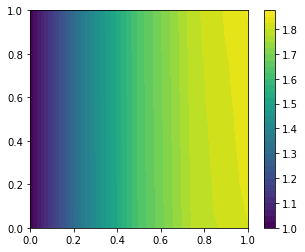

In [10]:
# Plot solution p0
fig = plot(p[0])
plt.colorbar(fig)

Calling FFC just-in-time (JIT) compiler, this may take some time.


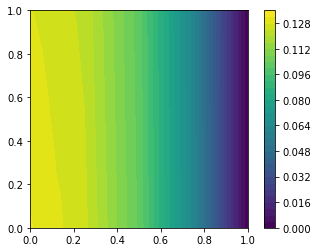

In [11]:
# Plot solution p1
fig = plot(p[1])
plt.colorbar(fig)

#### Exercise: Apply the multi-compartment Darcy's law model to the LV geometry from L21.

In [44]:
def load_ellipsoid_data():
    """Returns 4-tuple:
    mesh - the mesh, 
    mf - MeshFunction defining boundary markers, 
    numbering - dict of marking numbers,
    fibers - list of functions defining microstructure"""
    import dolfin
  
    mesh = dolfin.Mesh(dolfin.MPI.comm_world, "../L20-21A/data/mesh.xml")
    mf = dolfin.MeshFunction("size_t", mesh, "../L20-21A/data/facet_function.xml")

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # load fibers, sheet, cross_sheet data 
    fiber_element = dolfin.VectorElement(family="Quadrature",
                                     cell=mesh.ufl_cell(),
                                     degree=4,
                                     quad_scheme="default")
    fiber_space = dolfin.FunctionSpace(mesh, fiber_element)
    fiber = dolfin.Function(fiber_space, "../L20-21A/data/fiber.xml")
    sheet = dolfin.Function(fiber_space, "../L20-21A/data/sheet.xml")
    cross_sheet = dolfin.Function(fiber_space, "../L20-21A/data/cross_sheet.xml")

    fibers = [fiber,sheet, cross_sheet]
    
    return mesh, mf, numbering, fibers

mesh, boundary_markers, numbering, fibers = load_ellipsoid_data()

P1 = FiniteElement('P', mesh.ufl_cell(), 1)
ME = MixedElement([P1, P1])
P = FunctionSpace(mesh, ME) # mixed pressure space

# Define parameters
N = 2
K = [Constant(1), Constant(0.5)]
beta01 = Constant(0.2)
f = Constant(2)

bc_epi = DirichletBC(P.sub(0), Constant(10500), boundary_markers, 40)
bc_endo = DirichletBC(P.sub(1), Constant(3300), boundary_markers, 30)
bcs = [bc_epi, bc_endo]

# Define variational problem
p = TestFunction(P)
q = TrialFunction(P)
a = sum([K[i] * inner(grad(p[i]), grad(q[i])) for i in range(N)])*dx +\
                 beta01 * ((p[0]-p[1])*q[0] + (p[1]-p[0])*q[1])*dx
L = f*q[0]*dx

# Solve
p = Function(P)
solve(a == L, p, bcs=bcs)

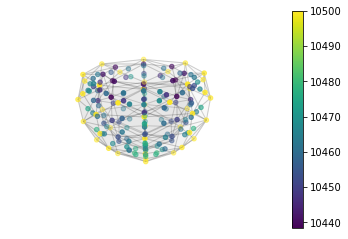

In [45]:
# Plot solution p0
plot(mesh, alpha=0.1, edgecolor='k', color='w')
fig = plot(p[0])
plt.colorbar(fig)

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()

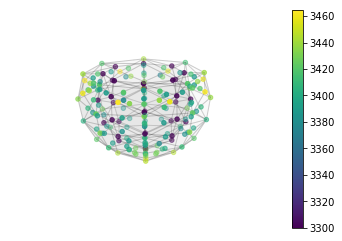

In [46]:
# Plot solution p0
plot(mesh, alpha=0.1, edgecolor='k', color='w')
fig = plot(p[1])
plt.colorbar(fig)

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()

#### Exercise: Use your results from L21 (contraction modelling) to drive the perfusion model

In [91]:
from guccionematerial import *

mesh, boundary_markers, numbering, fibers = load_ellipsoid_data()
V = VectorFunctionSpace(mesh, 'P', 1)

u_file = XDMFFile("contraction/u.xdmf")
p0_file = XDMFFile("contraction/p0.xdmf")
p1_file = XDMFFile("contraction/p1.xdmf")

# Define strain measures
u = Function(V)
I = Identity(3) # the identity matrix
F = I + grad(u) # the deformation gradient
F = variable(F)
J = variable(det(F))

mat = GuccioneMaterial(e1=fibers[0],e2=fibers[1],e3=fibers[2],kappa=1e3,Tactive=0.0)
psi = mat.strain_energy(F)

P = FunctionSpace(mesh, 'P', 1) # pressure space
p_D = Function(P)

# Define parameters
N = 2
K = [Constant(1), Constant(0.5)]
beta01 = Constant(0.5)
f = Constant(0)

bc_endo = DirichletBC(P, Constant(0), boundary_markers, 30)
bcs = [bc_endo]

# Define variational problem
p = TestFunction(P)
q = TrialFunction(P)
R = K[1] * inner(grad(p), grad(q))*dx + beta01*(p_D)*q*dx - f*q*dx
a, L = lhs(R), rhs(R)

steps = 40
dt = 1/steps
t = 0.0
for i in range(steps):
    u_file.read_checkpoint(u, 'u', i)
    
    p_D.assign(project(inner(diff(psi, F), F.T), P))
    
    p = Function(P)
    solve(a == L, p, bcs=bcs)
    
    print(assemble(p_D*dx))
    print(assemble(p*dx))
    
    p0_file.write_checkpoint(p_D, 'p0', t, append=True)
    p1_file.write_checkpoint(p, 'p1', t, append=True)
    
    t += dt
    
u_file.close()
p0_file.close()
p1_file.close()

              Calling FFC just-in-time (JIT) compiler, this may take some time.
0.0
0.0
3.914011163757045
0.0
8.484637300140315
0.0
13.73805234130044
0.0
19.61972142292502
0.0
26.011130704528963
0.0
32.79365647541139
0.0
39.88438541611846
0.0
47.23142789206358
0.0
54.80095763688954
0.0
62.56894345832523
0.0
70.51705509918808
0.0
78.63067901609372
0.0
86.89787170401341
0.0
95.30873012046627
0.0
103.85496240238929
0.0
112.52956833928243
0.0
121.3265897702739
0.0
130.24091126226293
0.0
139.26809959334835
0.0
139.26809959334835
0.0
136.87771255650426
0.0
134.3813690319172
0.0
131.76300460799987
0.0
129.0027548900404
0.0
126.07567342445014
0.0
122.95007153402477
0.0
119.5856096839958
0.0
115.9317996498677
0.0
111.92892815687576
0.0
107.51599446676751
0.0
102.65252761099454
0.0
97.35439054552678
0.0
91.71723157997152
0.0
85.89432185724355
0.0
80.05661151028873
0.0
74.38276816703167
0.0
69.06453422142836
0.0
64.28010051287787
0.0
60.1323970333823
0.0
